In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

In [1]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

Using TensorFlow backend.


In [2]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

Wall time: 21.8 s


### Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

#### Взаимная информация

In [3]:
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

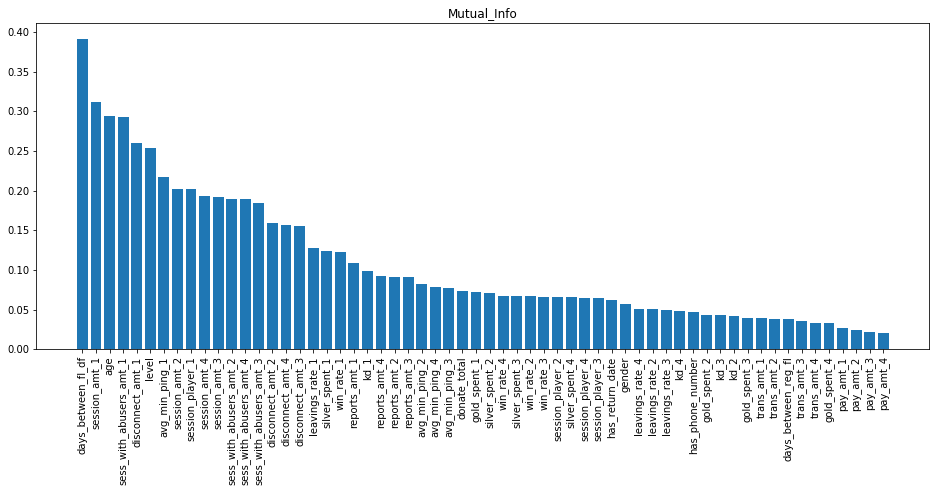

In [4]:
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [5]:
X_train_mi = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_mi = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_mi, y_train_balanced, X_test_mi, y_test)

Precision: 0.2906592450861019
Recall: 0.4028447444551591
F1: 0.33767808426796
Log Loss: 0.13386851718936327
ROC AUC: 0.8950541061947208


Значение F1 незначительно упало по сравнению с моделью, обученной на всех признаках.

#### RFE (Recursive Feature Elimination)

In [6]:
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 50


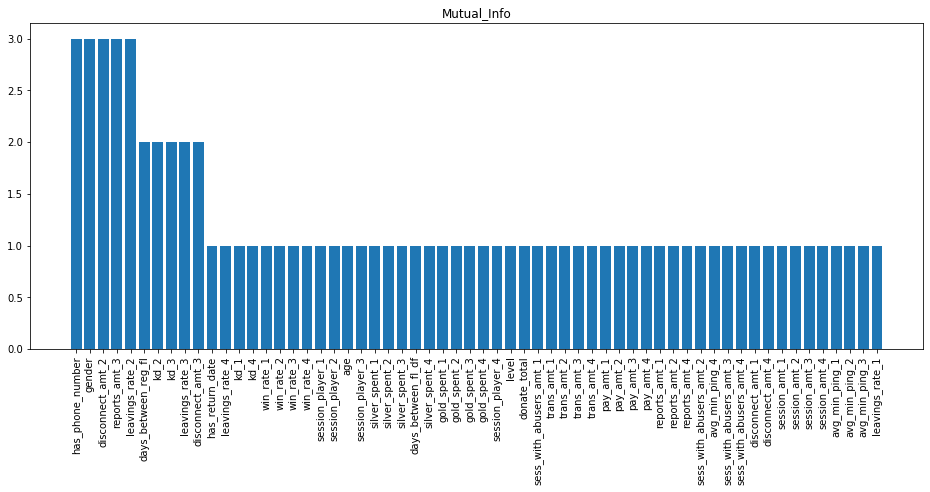

In [7]:
feature_importance = plot_importance(selector.ranking_, X.columns, 'Mutual_Info')

In [8]:
good_features

Index(['level', 'donate_total', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3',
       'trans_amt_4', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4',
       'reports_amt_1', 'reports_amt_2', 'reports_amt_4',
       'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2',
       'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4',
       'disconnect_amt_1', 'disconnect_amt_4', 'session_amt_1',
       'session_amt_2', 'session_amt_3', 'session_amt_4', 'avg_min_ping_1',
       'avg_min_ping_2', 'avg_min_ping_3', 'avg_min_ping_4', 'leavings_rate_1',
       'leavings_rate_4', 'kd_1', 'kd_4', 'win_rate_1', 'win_rate_2',
       'win_rate_3', 'win_rate_4', 'session_player_1', 'session_player_2',
       'session_player_3', 'session_player_4', 'silver_spent_1',
       'silver_spent_2', 'silver_spent_3', 'silver_spent_4', 'gold_spent_1',
       'gold_spent_2', 'gold_spent_3', 'gold_spent_4', 'age',
       'days_between_fl_df', 'has_return_date'],
      dtype='object')

In [9]:
X_train_rfe = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_rfe = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.29742033383915023
Recall: 0.4252651880424301
F1: 0.35003472566722893
Log Loss: 0.1321238859970634
ROC AUC: 0.8988767507909813


Значение F1 увеличилось.

#### Permutation Importance (PI)

In [10]:
from ELI5 import PermutationImportance

In [11]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.29072130037250254
Recall: 0.4139344262295082
F1: 0.341555599761289
Log Loss: 0.13381921435103247
ROC AUC: 0.8972594590163581


In [12]:
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

In [13]:
res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

In [14]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

Кол-во отобранных признаков: 33


In [15]:
good_features

0               session_amt_1
1     sess_with_abusers_amt_1
2                 trans_amt_1
3                 trans_amt_2
4            disconnect_amt_1
5                       level
6               reports_amt_1
7          days_between_fl_df
8                 trans_amt_3
9               session_amt_4
10              session_amt_2
11              reports_amt_4
12                trans_amt_4
13            leavings_rate_1
14                 win_rate_1
15              reports_amt_2
16             avg_min_ping_1
17             silver_spent_1
18           disconnect_amt_4
19                        age
20           disconnect_amt_2
21           disconnect_amt_3
22              session_amt_3
23              reports_amt_3
24               donate_total
25            has_return_date
26            leavings_rate_4
27               gold_spent_1
28           session_player_3
29            leavings_rate_3
30             silver_spent_2
31                       kd_3
32             silver_spent_3
Name: feat

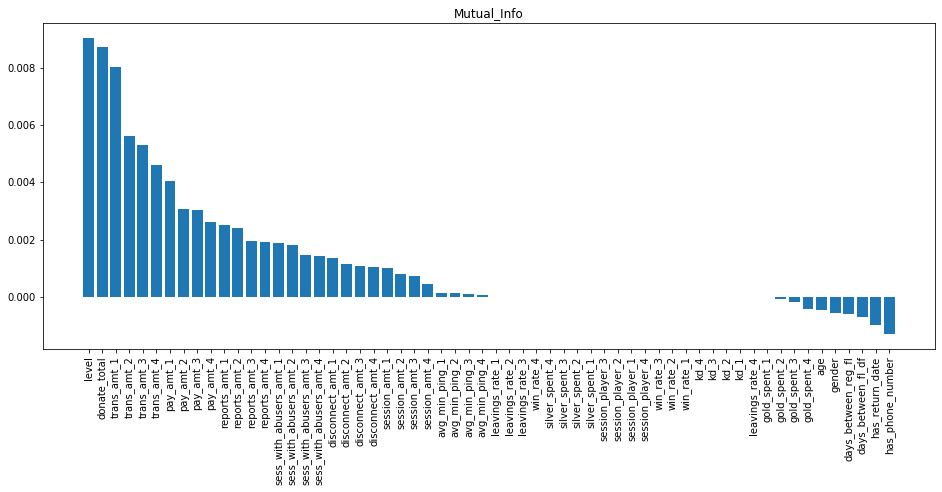

In [16]:
feature_importance = plot_importance(res['score'], X.columns, 'Mutual_Info')

In [17]:
X_train_pi = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_pi = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_pi, y_train_balanced, X_test_pi, y_test)

Precision: 0.2936822172490962
Recall: 0.41128254580520734
F1: 0.34267349603294167
Log Loss: 0.13319970933443834
ROC AUC: 0.8966963489905643


F1 незначительно вырос по сравнению с моделью, обученной на всех признаках.

#### Итого, лучшее качество было получено на признаках, отобранных методом RFE (Recursive Feature Elimination).

### Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

In [18]:
# В качестве классификатора возьмем RandomForest
from sklearn.ensemble import RandomForestClassifier

In [19]:
def rf_fit_predict(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(n_estimators=200,
                                n_jobs=-1,
                                random_state=5)

    clf.fit(X_train, y_train)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [20]:
# Обучим на всех признаках для сравнения.
fitted_rf = rf_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.3762227238525207
Recall: 0.24108003857280616
F1: 0.29385836027034967
Log Loss: 0.11160660245917035
ROC AUC: 0.9061873770812785


In [21]:
# Хи-квадрат
chi2_test = chi2(X_train_balanced, y_train_balanced)

X_train_CHI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_CHI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = rf_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)

Precision: 0.3446808510638298
Recall: 0.2148023143683703
F1: 0.26466656765186397
Log Loss: 0.11360988965333979
ROC AUC: 0.897525261685464


In [22]:
# RFE (Recursive Feature Elimination)
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(5), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]

In [23]:
X_train_rfe = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_rfe = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = rf_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.3614678899082569
Recall: 0.23746383799421408
F1: 0.2866288374799942
Log Loss: 0.11280111362292437
ROC AUC: 0.9039910902235627


Результат модели, использующей в качестве классификатора RandomForest оказался ниже XGBoost. При этом на отбранных признаках при помощи метода Хи-квадрат результат понизился еще больше. Метод RFE, повышавший качество модели XGBoost, в этом случае тоже только ухудшил картину.

In [24]:
# Вторая модель - LogisticRegression
from sklearn.linear_model import LogisticRegression

In [25]:
def lr_fit_predict(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(n_jobs=-1,
                                random_state=5)

    clf.fit(X_train, y_train)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [26]:
# Хи-квадрат

fitted_clf = lr_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)

Precision: 0.20254710397766923
Recall: 0.279893924783028
F1: 0.23502024291497978
Log Loss: 0.25801724416780497
ROC AUC: 0.7732737253039563


In [27]:
# RFE (Recursive Feature Elimination)

fitted_clf = lr_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.20436951660072253
Recall: 0.28640308582449375
F1: 0.238530268045377
Log Loss: 0.2570166935547763
ROC AUC: 0.7746418613569412


Логистическая регрессия и отбор признаков не дали хороших результатов.

### Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [28]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

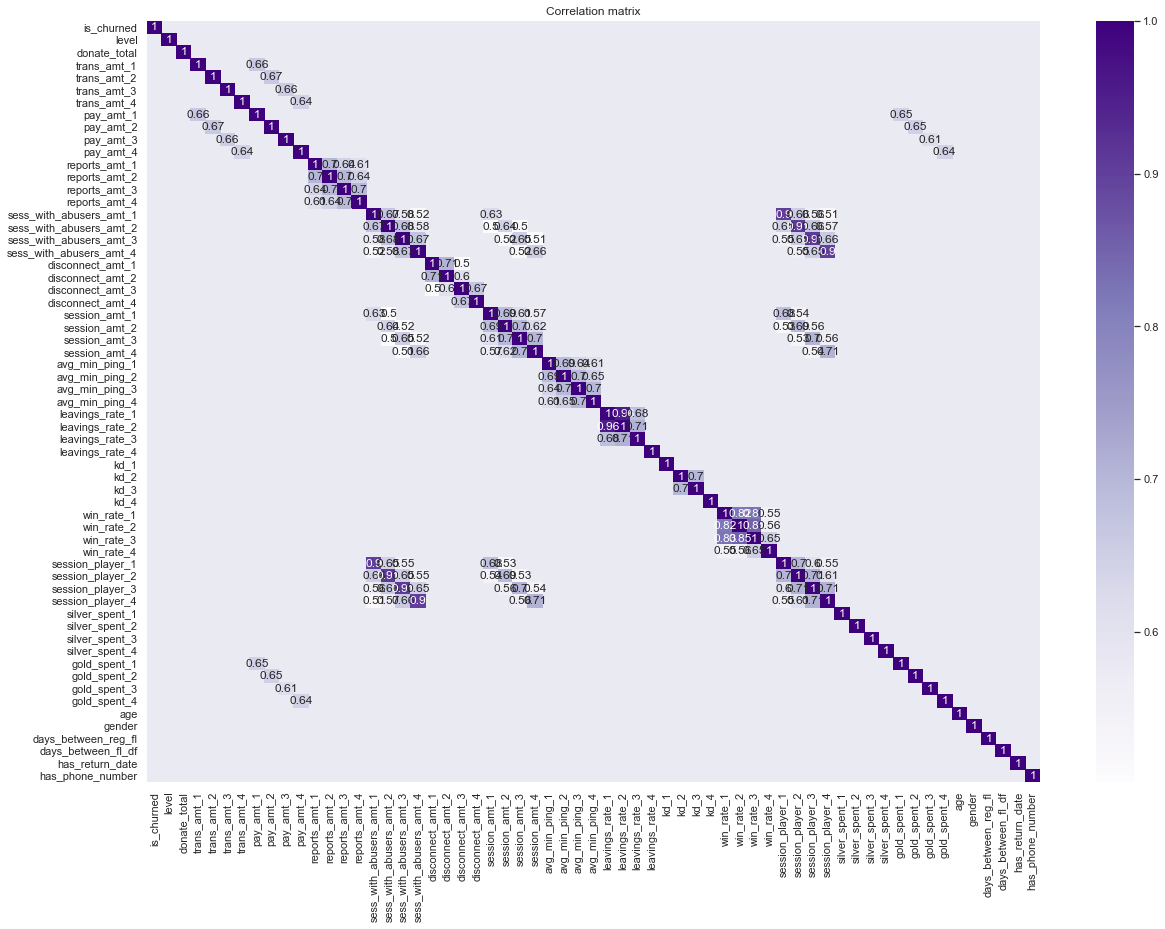

In [29]:
plt.figure(figsize=(20, 14))
sns.heatmap(dataset.corr()[(dataset.corr()>0.5)], cmap='Purples', annot=True)
plt.title('Correlation matrix');

Как видно из графика, целевая переменная не имеет ярко выраженной линейной зависимости ни от одного из признаков. При этом некоторые признаки имеют сильную корреляцию друг с другом. Количество линейно зависимых признаков можно сократить при помощи метода главных компонент.

In [30]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components=30, svd_solver='full')
X_mm_pca = pca.fit_transform(X_mm)

pca.explained_variance_ratio_

array([2.99822202e-01, 2.43844199e-01, 1.79991399e-01, 1.28055801e-01,
       3.91333651e-02, 3.29362666e-02, 2.40848553e-02, 1.01013296e-02,
       6.83406312e-03, 6.07497227e-03, 4.23191868e-03, 3.86888256e-03,
       3.03661434e-03, 2.79969658e-03, 2.26029032e-03, 1.45564757e-03,
       1.44678218e-03, 1.09697533e-03, 1.08531534e-03, 8.99139280e-04,
       8.88235146e-04, 8.79261448e-04, 6.87693172e-04, 5.82601348e-04,
       5.40702900e-04, 5.28373603e-04, 3.84803629e-04, 3.09936060e-04,
       2.76856445e-04, 2.46341461e-04])

In [44]:
pca.singular_values_

array([260.56133885, 234.98183801, 201.88495684, 170.28551628,
        94.13511983,  86.36052371,  73.84993258,  47.82636285,
        39.33848003,  37.08943627,  30.95613554,  29.59857862,
        26.222428  ,  25.17871522,  22.62352089,  18.15541594,
        18.10004512,  15.76073665,  15.67675073,  14.26893528,
        14.18214951,  14.11032765,  12.47887512,  11.48586812,
        11.06515322,  10.93826999,   9.33464191,   8.37749421,
         7.91781594,   7.46873137])

In [45]:
X_mm_pca.shape

(469475, 30)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_mm_pca, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

In [47]:
# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

In [48]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.24340583063396576
Recall: 0.5072324011571842
F1: 0.32895559724828016
Log Loss: 0.19598067546188916
ROC AUC: 0.86998152469249


Мы уменьшили количество признаков в два раза и получили качество чуть хуже, чем при обучении модели на всех признаках.

### (*) Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте.

Information Value был создан специально для логистической регрессии и не может использоваться в других моделях, таких как случайный лес.